# **<center>EDA**

### Import packages

In [1]:
import os

from dotenv import load_dotenv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import requests
from bs4 import BeautifulSoup
import zipfile

from tqdm import tqdm

#### Set Preferences

In [3]:
# Whenever I call .head() I want to see the entire dataset
pd.set_option('display.max_columns', None)
# For my eyes
plt.style.use('dark_background')

#### Set Directory

In [4]:
# Load in the dotenv variables
load_dotenv()

# Get the project path while not having to deal with the "" that get added
project_path = os.getenv('Project_Path')[2:78]

# Change notebook directory back one so that it can acess the data
os.chdir(project_path)

### Load the data

In [5]:
# Load the cleaned data from data wrangling
data = pd.read_csv('./data/interim/wrangled', low_memory = False)
# Load in the loan_status column for use
loan = pd.read_csv('./data/raw/loan.csv',low_memory = False)
# Load the original dataset to get the accurate representation
y = loan['loan_status']

In [5]:
data.head(3)

,loan_amnt,term,grade,annual_inc,pymnt_plan,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,dti_joint,tot_cur_bal,open_acc_6m,il_util,max_bal_bc,inq_last_12m,emp_type_Accountant,emp_type_Admin,emp_type_Analyst,emp_type_Assistant,emp_type_Clergy,emp_type_Clerk,emp_type_Designer,emp_type_Director,emp_type_Education,emp_type_Executive,emp_type_Healer,emp_type_Manager,emp_type_Operator,emp_type_Technical,emp_type_Vol,home_ownership_OTHER,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_major_purchase,purpose_other,purpose_small_business,purpose_wedding,addr_state_AL,addr_state_CO,addr_state_DC,addr_state_FL,addr_state_IL,addr_state_KS,addr_state_ME,addr_state_MS,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NV,addr_state_NY,addr_state_SC,addr_state_TX,addr_state_VA
0,-1.156460,-0.654724,0.763889,-0.789014,-0.003357,0.305877,-0.335522,-0.145932,1.201140,-1.373775,-0.97077,-0.415561,0.302329,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,-0.768632,1.431317,1.817653,-0.140912,-0.225373,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612
1,-1.452829,1.527360,-0.314193,-0.696292,-0.003357,4.312132,-0.335522,-0.679268,-1.912396,-1.796028,-0.97077,-0.426398,-3.540893,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,1.301013,-0.698657,-0.550160,-0.140912,-0.225373,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612
2,-1.464683,-0.654724,-0.468204,-0.970563,-0.003357,1.307441,-0.335522,-0.622684,1.821333,-1.289324,-0.97077,-0.315809,0.302329,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,-0.768632,-0.698657,-0.550160,-0.140912,-0.225373,9.193151,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,4.900357,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612


In [6]:
# Create a loop over all the different attack types
for col in data.columns:
    # Print out the attack types in bullet format to make the next section easier
    print(f"- {col}")

- loan_amnt
- term
- grade
- annual_inc
- pymnt_plan
- inq_last_6mths
- pub_rec
- revol_bal
- revol_util
- total_acc
- initial_list_status
- last_pymnt_amnt
- last_credit_pull_d
- collections_12_mths_ex_med
- mths_since_last_major_derog
- dti_joint
- tot_cur_bal
- open_acc_6m
- il_util
- max_bal_bc
- inq_last_12m
- emp_type_Accountant
- emp_type_Admin
- emp_type_Analyst
- emp_type_Assistant
- emp_type_Clergy
- emp_type_Clerk
- emp_type_Designer
- emp_type_Director
- emp_type_Education
- emp_type_Executive
- emp_type_Healer
- emp_type_Manager
- emp_type_Operator
- emp_type_Technical
- emp_type_Vol
- home_ownership_OTHER
- home_ownership_RENT
- verification_status_Source Verified
- verification_status_Verified
- purpose_credit_card
- purpose_major_purchase
- purpose_other
- purpose_small_business
- purpose_wedding
- addr_state_AL
- addr_state_CO
- addr_state_DC
- addr_state_FL
- addr_state_IL
- addr_state_KS
- addr_state_ME
- addr_state_MS
- addr_state_ND
- addr_state_NE
- addr_state_NH


## **Basic Analysis**

While it may be possible to intuit many of the column names from the dataset it is important to define all of these columns.

- **loan_amnt:** The amount the loan was for
- **term**: The length of the loan
- **grade:** The grade that Lending Club assigns the borrower to set an interest rate and give the investors some information.
- **annual_inc:** The income of the borrower per year. This also includes joint income if the borrower has another person that is contributing to the application
- **pymnt_plan:** Indicates whether or not the borrower is on a payment plan to get back to being up to date on their payments.
- **inq_last_6mths:** The number of inquiries in the last 6 months excluding auto and mortgage inquiries.
- **pub_rec:** The number of derogatory public records that the borrower has
- **revol_bal:** Total balance for the borrower's revolving credit line
- **revol_util:** The amount of credit the borrower is using compared to the revolving limit
- **total_acc:** total number of accounts on the borrower's file
- **initial_list_status:** The type of loan that it is values are 0 and 1
- **last_pymnt_amnt:** The amount that the borrower paid the last time a payment was made.
- **last_credit_pull_d:** The last time that lending club had to pull the borrower's credit for the loan. I filled in missing values as the same month as the issue date
- **collections_12_mths_ex_med:** The number of collections in the last 12 months exluding medical
- **mths_since_last_major_derog:** The amount of months since the last 90-day rating or worse rating
- **dti_joint:** Binary variable that is higher when the dti number is joint.
- **tot_cur_bal:** Total current balance of all accounts
- **open_acc_6m:** The number of open trade accounts in the last 6 months
- **il_util:** Ratio of tot_cur_bal to the credit limit on installment accounts
- **max_bal_bc:** Maximum balance owed on all revolving accounts 
- **inq_last_12m:** The number of inquiries into the borrower in the last 12 months excluding auto and mortgage inquiries.
- **emp_type_...:** Dummy Variables representing the profession of the borrower.
- **home_ownership_...:** Dummy Variables representing the home_ownership situation of the borrower.
- **verification_status_...:** Dummy variables representing Lending Clubs level of verification for the borrower
- **purpose_...:** Dummy variables that are the reason that the borrower took out the loan. Higher value indicates yes
- **addr_state_...:** Dummy variables that higher if the borrower is from that state. The three dots at the end represent the initials of the state

In [7]:
# Create a loop over all the different attack types
for type in y.unique():
    # Print out the attack types in bullet format to make the next section easier
    print(f"- {type}")

- Fully Paid
- Charged Off
- Current
- Default
- Late (31-120 days)
- In Grace Period
- Late (16-30 days)
- Does not meet the credit policy. Status:Fully Paid
- Does not meet the credit policy. Status:Charged Off
- Issued


- **Fully Paid:** The loan has be fully repaid on time in its entirety
- **Charged Off:** The loan has not been fully repaid and has been written off as not fully recoverable
- **Current:** The borrower is up to date on all the payments but the term of the loan has not expired and there are payments remaining
- **Default:** The late period has passed and lending club has started the process of charging off the loan
- **Late (31-120 days):** The borrower is late on a payment by 31-121 days
- **In Grace Period:** The borrower is within the grace period of p
- **Late (16-30 days):** The borrower is late on their payment by 16-30 days 
- **Does not meet the credit policy. Status:Fully Paid:** Lending club has a standard for credit scores that its applicants must meet. If they don't they cannot continue the loan. These borrowers did not have a high enough credit but still managed to fully pay back their loan.
- **Does not meet the credit policy. Status:Charged Off:** Similar to the above borrowers these people did not meet the minimum credit requirements. Unfortunately they were not able to pay back their loan and the loan was charged off
- **Issued:** The Loan has been issued but no payments have been made yet.


Below are plots for the distributions of the first twelve features before the dummy variables. Some of the 12 features are dummy variables themselves but the majority of them have more than 2 unique values.

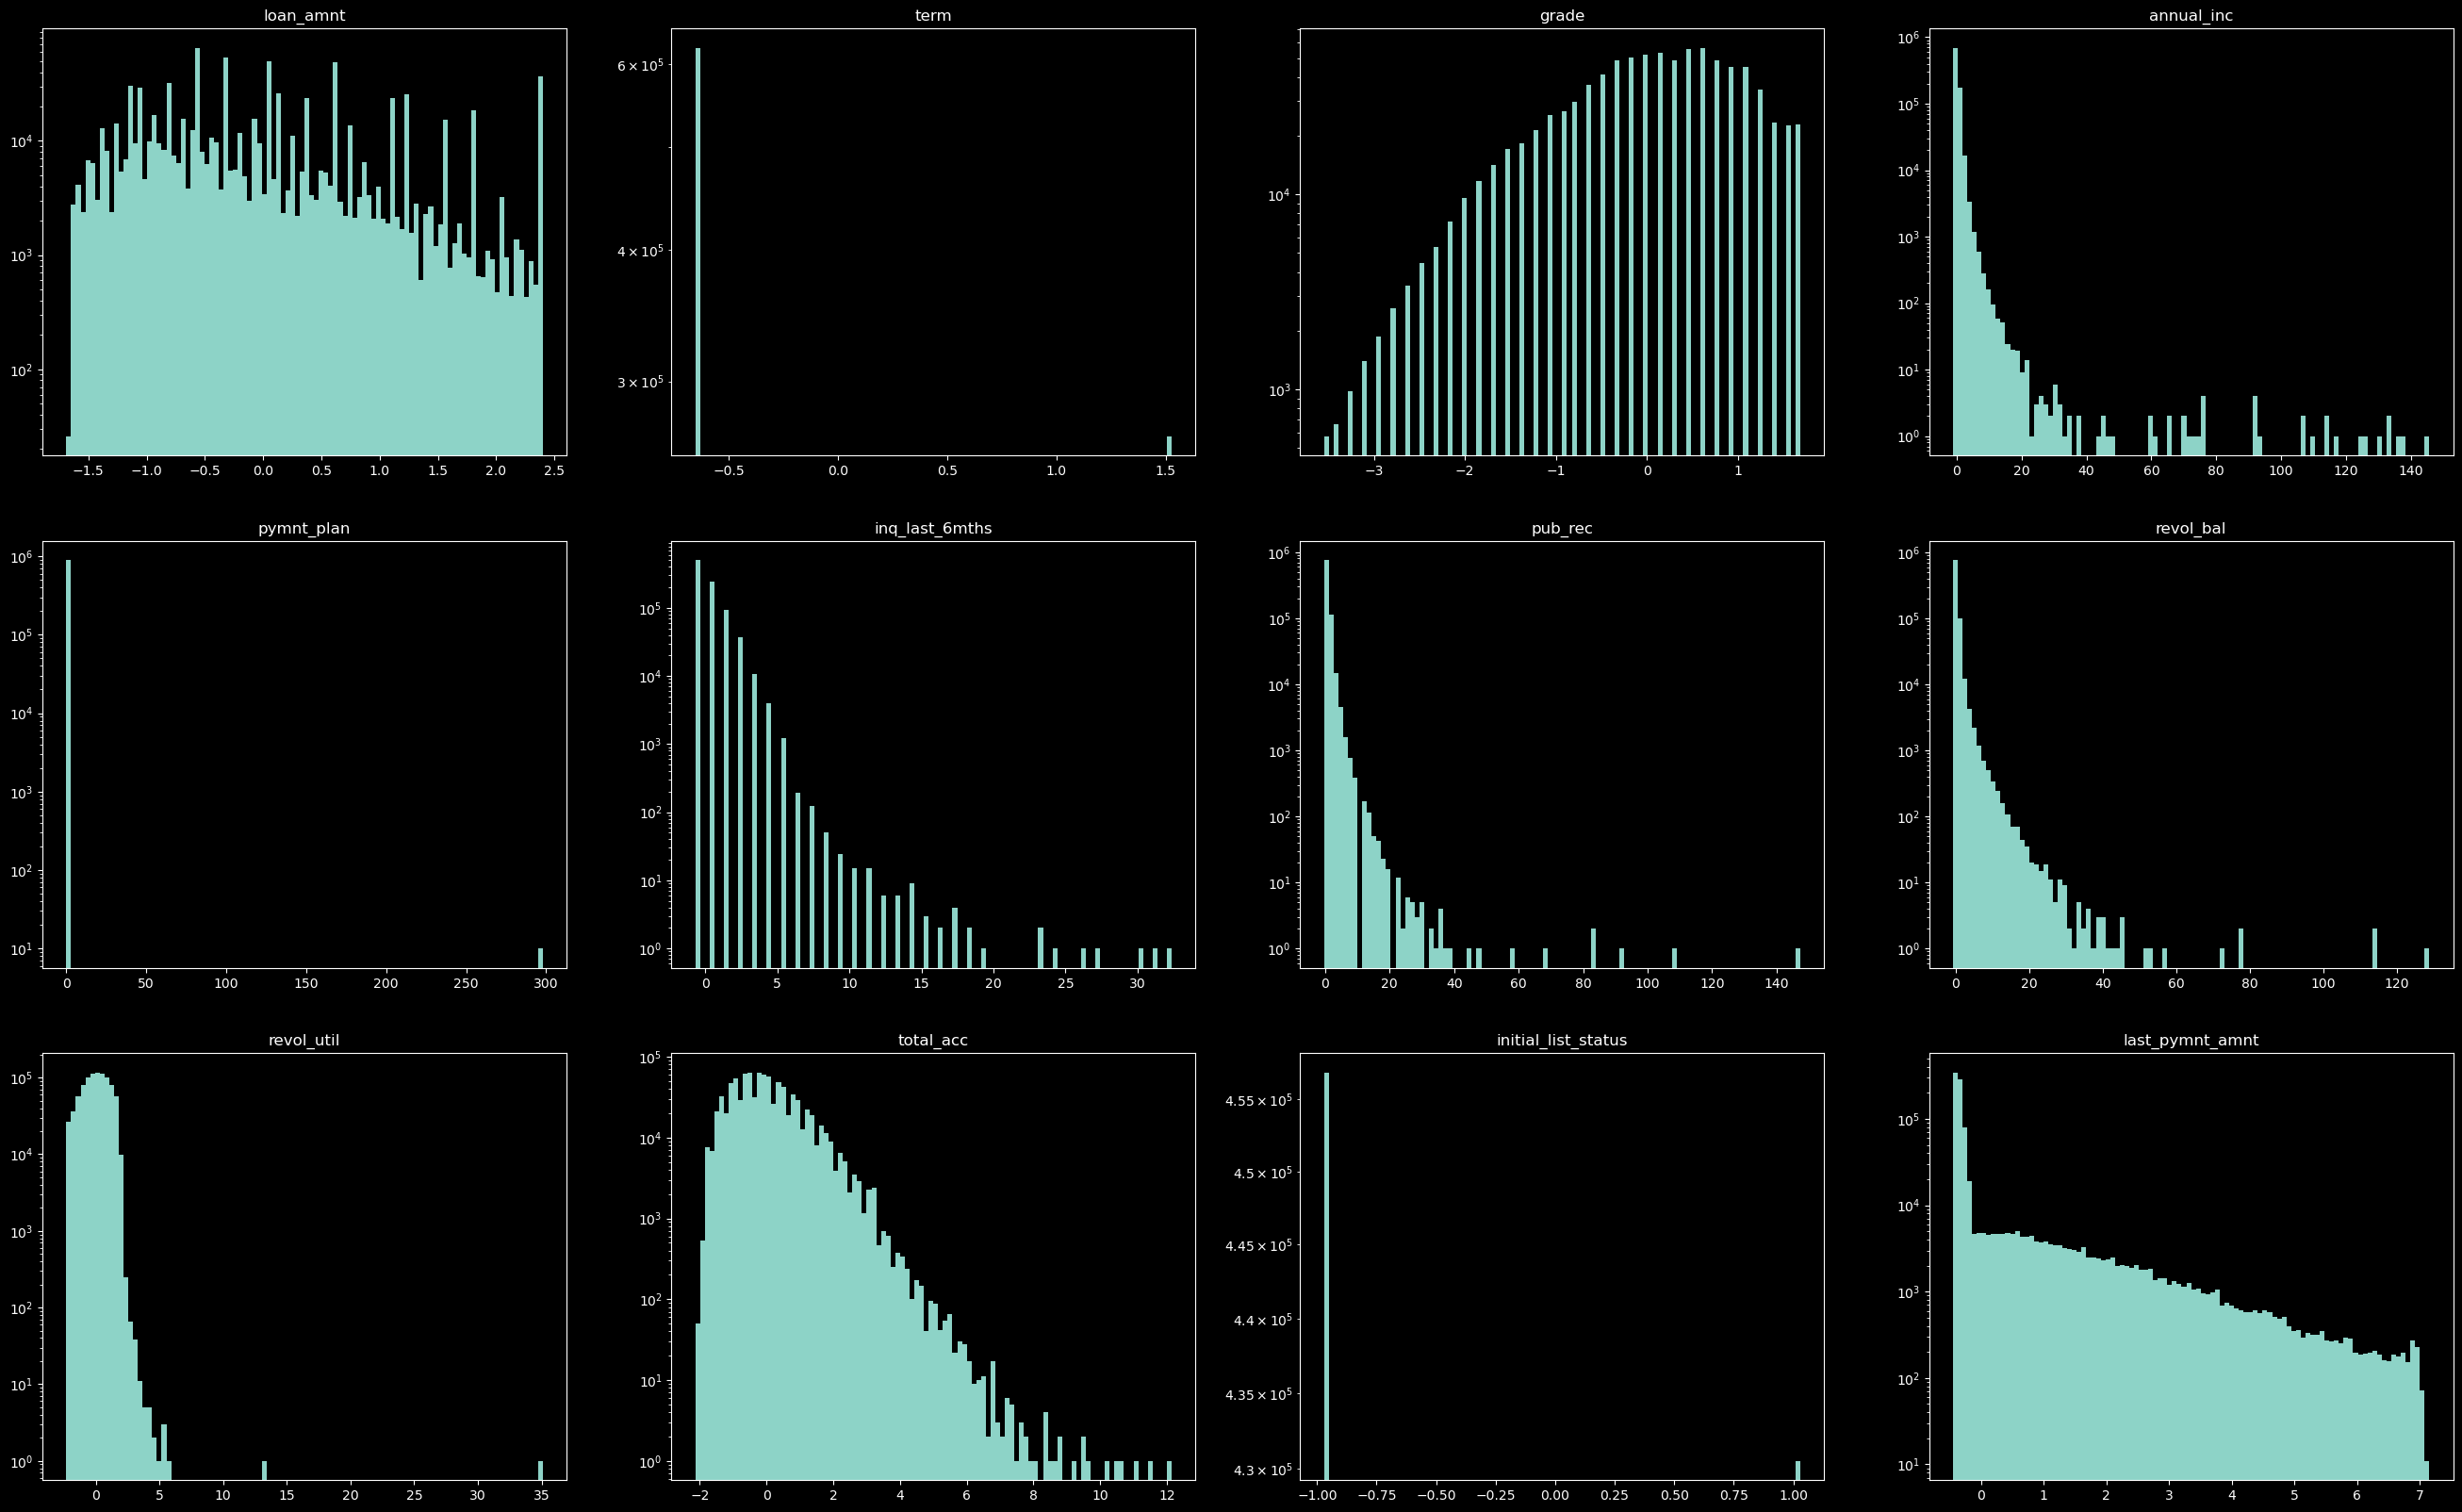

In [8]:
fig, ax = plt.subplots(3,4, figsize = (33,20))
columns = list(data.columns)
# Iterate over the first 12 features that aren't dummy variables
for i in range(12):
    # as i is iterating 0-11, the indexes are taking the remainder and 
    # mult floor so as to place it on the grid. 
    ax[i//4, i % 4].hist(x = data.iloc[:,i], bins = 100) 
    ax[i//4, i % 4].set_title(columns[i])
    ax[i//4, i % 4].set_yscale('log')

pymnt_plan, term, initial_list_status are all dummy variables that have a very low positive occurence. revol_util and revol_bal appear to be the only distributions that have clear outliers. Since revol_util is revol_bal divided by the credit limit they are tied together in having similar data points

### Correlations

A simple way to test how the features impact the status of the loans is to generate a heatmap of the correlations between the statuses that the loan could be in vs. the features of the dataset. Below I have split up the loan_status column into a dummy variable for each unique value so that I can see the unique correlations for each status to each feature.

100%|██████████| 61/61 [00:07<00:00,  7.81it/s]


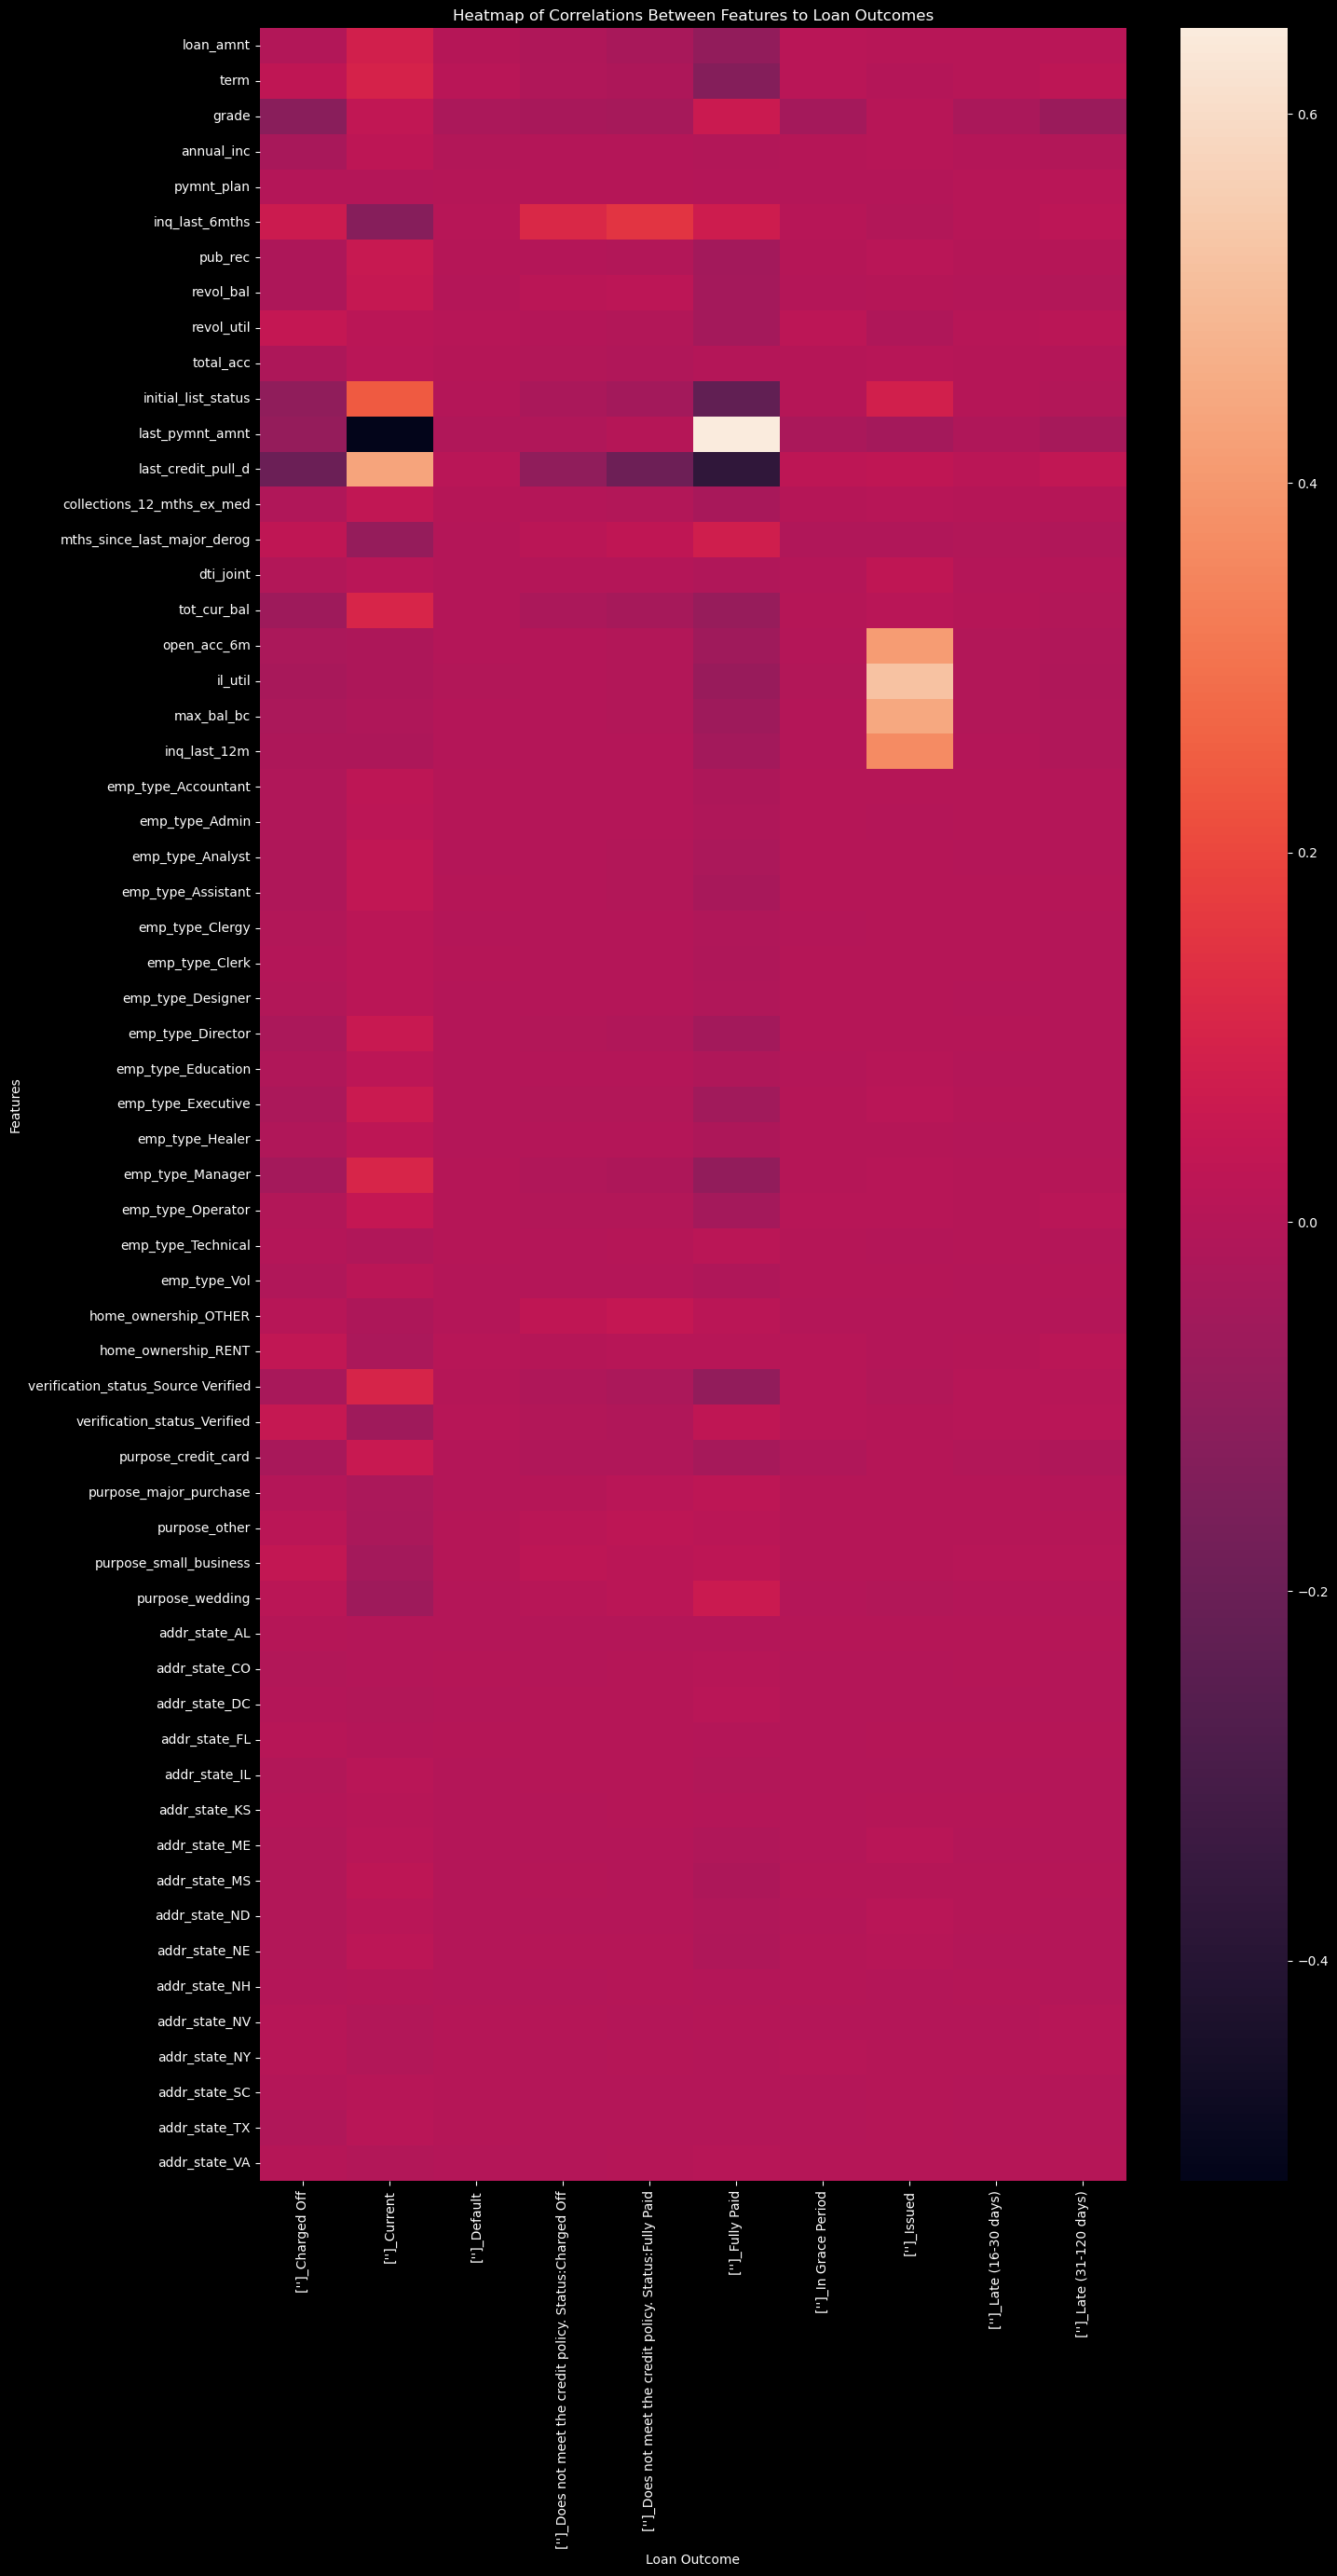

In [9]:
# create a matrix that stores each of the correlations between the features and statuses
corr_matrix = np.zeros((10,61))

# Create dummy variables for all the different loan statuses.
y_dummy = pd.get_dummies(y, prefix = [''])

# combine the y-dummy with the rest of the dataset
lab_dummy = pd.concat([data, y_dummy], axis = 1) 

# loop over the features
for k in tqdm(range(61)):
    # Loop over the different status labels
    for label in range(61,71):
        # Assign each part of the matrix the correlation between label and cluster
        corr_matrix[label-61, k] = lab_dummy.iloc[:,k].T.corr(other = lab_dummy.iloc[:,label])

# Turn the correlation matrix into a dataframe so it will be easier to manipulate
corr_df = pd.DataFrame(corr_matrix,
                       columns = lab_dummy.columns[:61],
                       index = lab_dummy.columns[61:])
     
#Back to darkmode for the eyes
plt.style.use('dark_background')
# Change the figure size so that all the intrusions types are legible
plt.figure(figsize = (15,30))
# Create a heatmap of correlation matrix to see each features highest correlations
sns.heatmap(corr_df.T);
# Label the axes
plt.xlabel("Loan Outcome");
plt.ylabel("Features");
# Give a title
plt.title("Heatmap of Correlations Between Features to Loan Outcomes");

In [10]:
y.value_counts(normalize = True)

Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64

Unfortunately it doesn't appear as though there is a lot of information in the heatmap. The imbalance of classes makes it hard for correlations to show and the only the most obvious columns appear to have high correlations. I can fix this by combining the target variable into a simple binary variable of loans that have been paid on time versus loans that are not current or fully paid.

In [11]:
y_binary = pd.DataFrame(np.where(y.isin(['Fully Paid', 'Current', 'Issued']), 1, 0), columns = ['y_bin'])

100%|██████████| 61/61 [00:00<00:00, 74.50it/s]


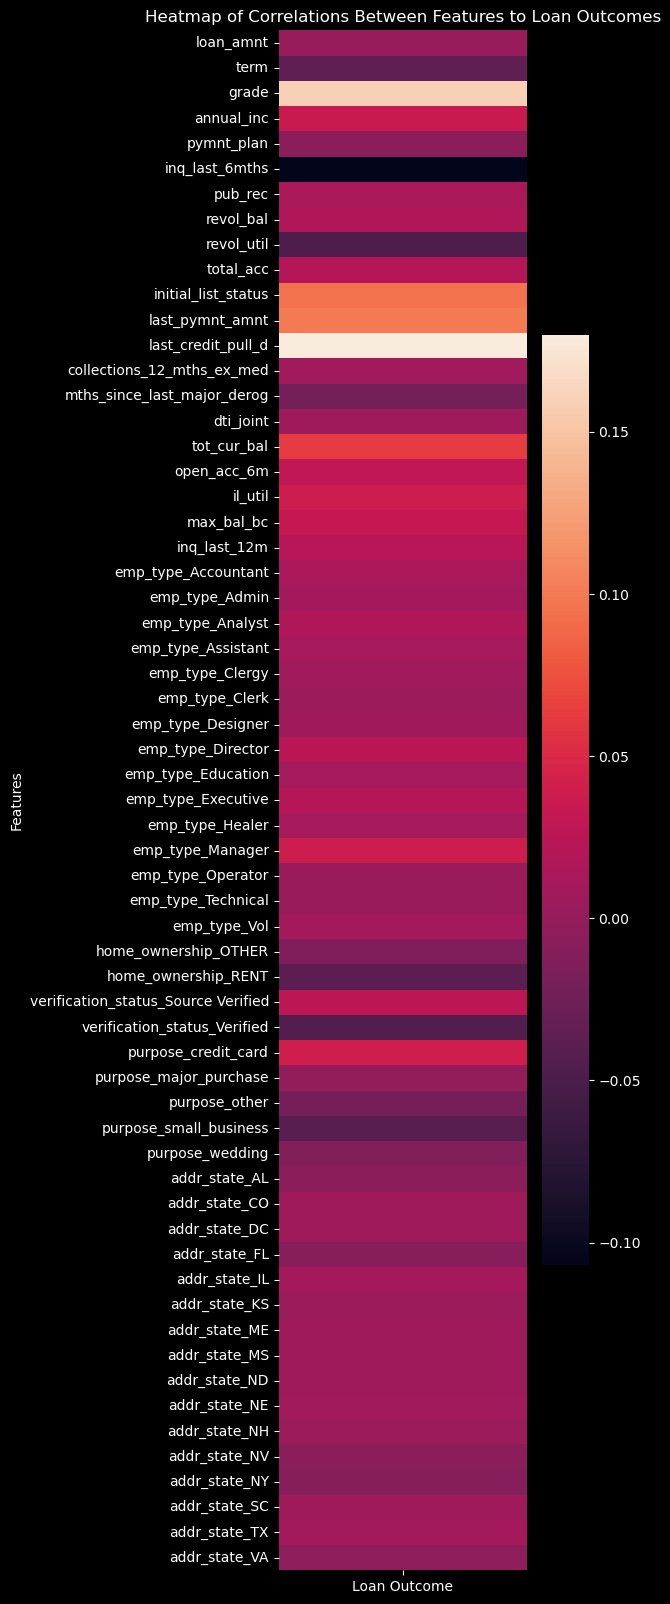

In [12]:
# create a matrix that stores each of the correlations between the clusters and labels
corr_matrix = np.zeros((1,61))

# combine the y-dummy with the rest of the dataset
lab_dummy = pd.concat([data, y_binary], axis = 1) 

# loop over the clusters
for k in tqdm(range(61)):
    # Assign each part of the matrix the correlation between label and cluster
    corr_matrix[0, k] = lab_dummy.iloc[:,k].T.corr(lab_dummy.iloc[:,-1])

# Turn the correlation matrix into a dataframe so it will be easier to manipulate
corr_df = pd.DataFrame(corr_matrix,
                       columns = lab_dummy.columns[:61],
                       index = ['Loan Outcome'])
     
#Back to darkmode for the eyes
plt.style.use('dark_background')
# Change the figure size so that all the intrusions types are legible
plt.figure(figsize = (4,20))
# Create a heatmap of correlation matrix to see each clusters highest intrusion correlations
sns.heatmap(corr_df.T);
# Label the axes
plt.ylabel("Features");
# Give a title
plt.title("Heatmap of Correlations Between Features to Loan Outcomes");

### Visualization

With out a clear path forward on the correlations, I can try to see if there is a structure in this dataset that would be helpful to analyze. If there is a structure then I can cluster the data and see how those clusters relate to the status of the loans. To do this I will first use Principal Component Analysis (PCA) to decompose the dataset into 2 vectors that can then be visualized. If there is a structure in the dataset, it should show up in the PCA graph.

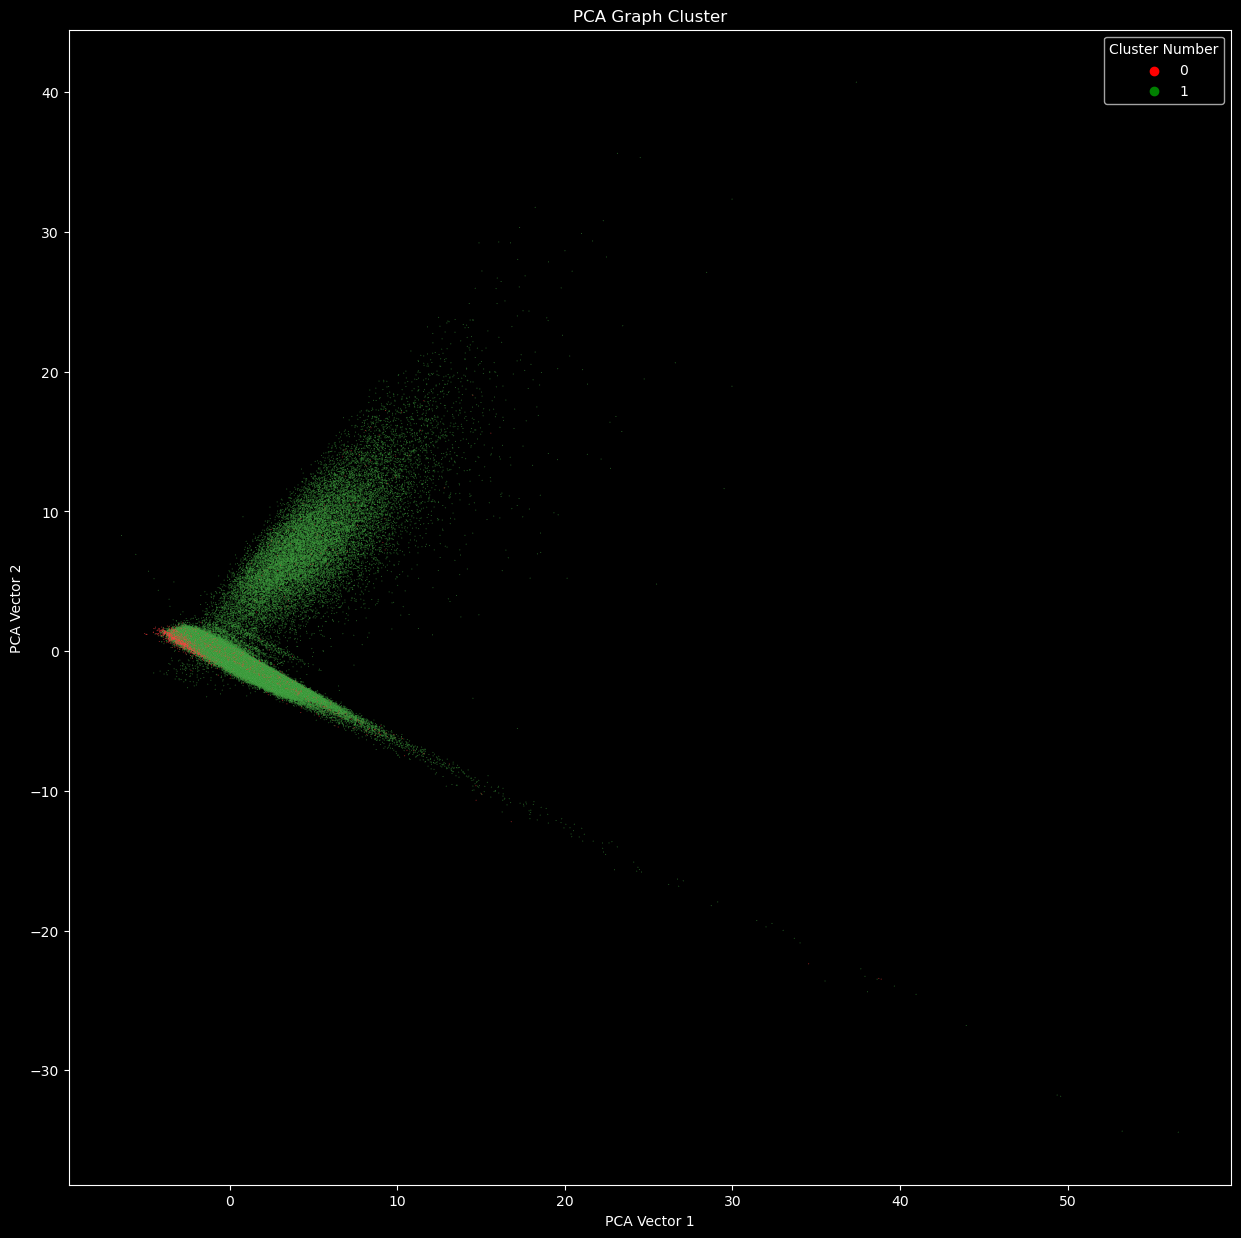

In [13]:
# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 2)
# create a data frame pca_vectors that has the two pca components 
pca_vectors = pd.DataFrame(pca.fit_transform(data), columns = ['1','2'])
# Combine the 2 components and the cluster that the label is a part of
pca_vectors = pd.concat([pca_vectors, y_binary], axis = 1)

# Make the figure size a lot bigger
plt.figure(figsize = (15,15))
# Plot all the points that aren't in the second cluster
sns.scatterplot(data = pca_vectors, x = '1', y = '2',
                # Legend = full took forever to figure out so that it doesn't leave out clusters
                hue = pca_vectors.iloc[:,-1], palette = ['red','green'], legend = 'full',  
                # Make points smaller and clearer since so many points overlap
                s = 0.4, alpha = 0.7);
# Label the x-axis
plt.xlabel('PCA Vector 1');
# Label the y-axis
plt.ylabel('PCA Vector 2');
# Show a legend to see which cluster each color represents
plt.legend(title = 'Cluster Number');
# Give the plot a title
plt.title("PCA Graph Cluster");

While there is a small clump in the left corner of the shape it is not clear that there is a clustered structure that would be predictive in the dataset. Much of the dataset contains dummy variables from single features that may be interfering with the shape of the PCA graph. Below I took out the dummy variables and plotted PCA with the remaining variables.

In [14]:
no_cat = data.drop(['emp_type_Accountant', 'emp_type_Admin',
       'emp_type_Analyst', 'emp_type_Assistant', 'emp_type_Clergy',
       'emp_type_Clerk', 'emp_type_Designer', 'emp_type_Director',
       'emp_type_Education', 'emp_type_Executive', 'emp_type_Healer',
       'emp_type_Manager', 'emp_type_Operator', 'emp_type_Technical',
       'emp_type_Vol', 'home_ownership_OTHER', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_major_purchase', 'purpose_other',
       'purpose_small_business', 'purpose_wedding', 'addr_state_AL',
       'addr_state_CO', 'addr_state_DC', 'addr_state_FL', 'addr_state_IL',
       'addr_state_KS', 'addr_state_ME', 'addr_state_MS', 'addr_state_ND',
       'addr_state_NE', 'addr_state_NH', 'addr_state_NV', 'addr_state_NY',
       'addr_state_SC', 'addr_state_TX', 'addr_state_VA'], axis = 1)

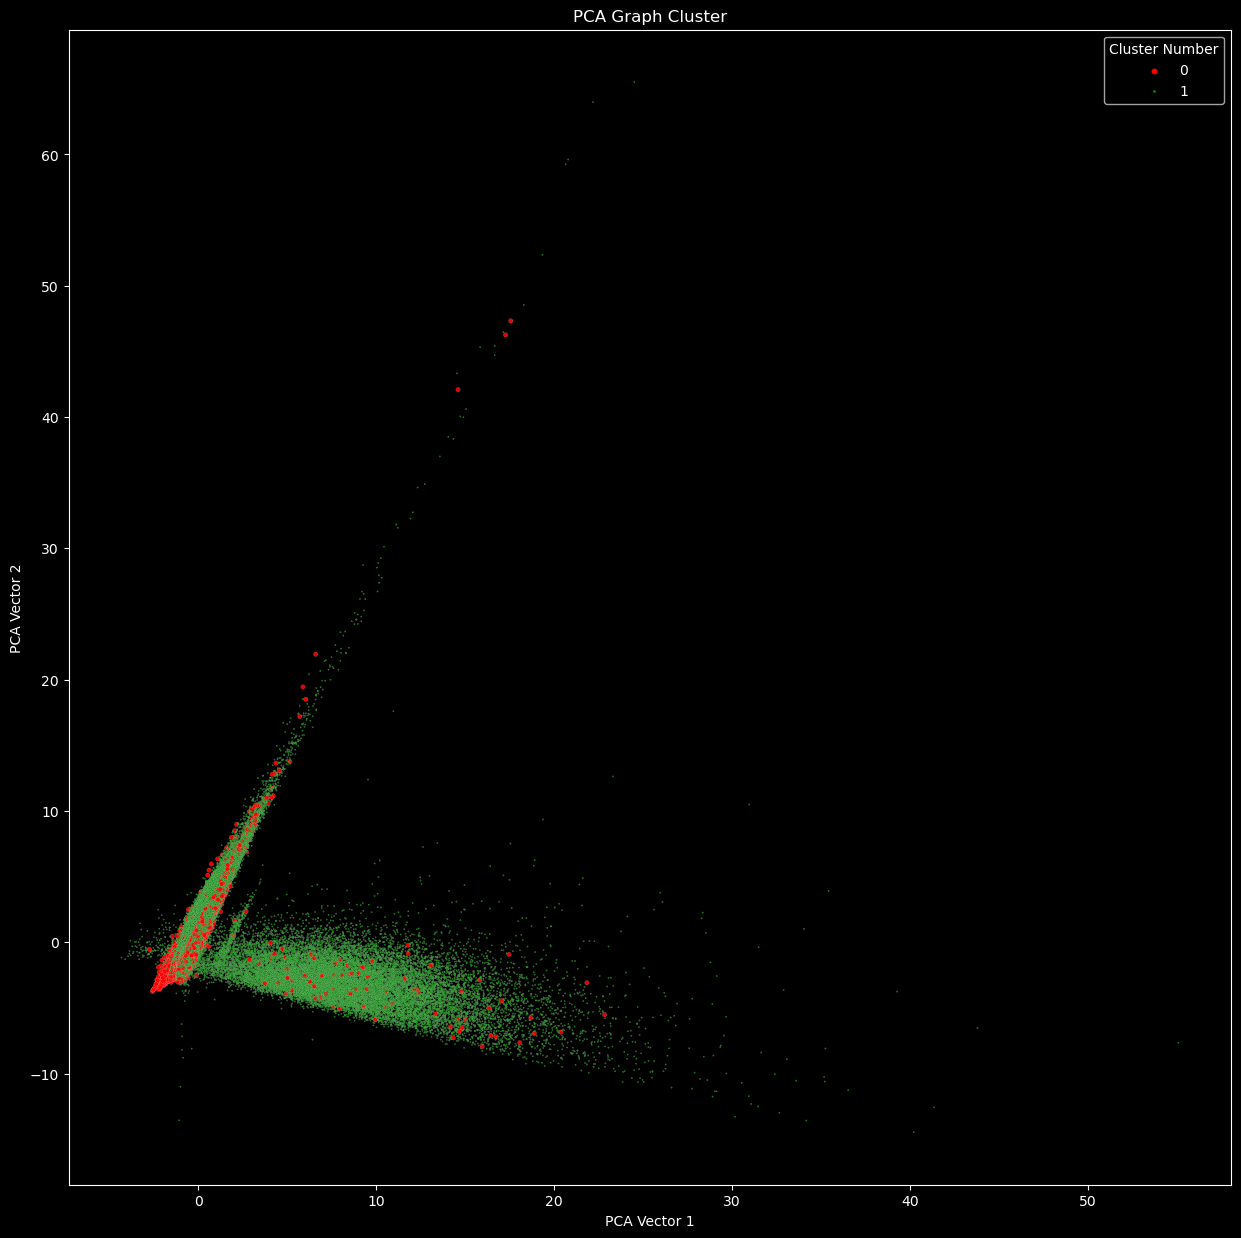

In [15]:
# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 2)
# create a data frame pca_vectors that has the two pca components 
pca_vectors = pd.DataFrame(pca.fit_transform(no_cat), columns = ['1','2'])
# Combine the 2 components and the cluster that the label is a part of
pca_vectors = pd.concat([pca_vectors, y_binary], axis = 1)

# Make the figure size a lot bigger
plt.figure(figsize = (15,15))
# Plot all the points that aren't in the second cluster
sns.scatterplot(data = pca_vectors, x = '1', y = '2',
                # Legend = full took forever to figure out so that it doesn't leave out clusters
                hue = pca_vectors.iloc[:,-1], palette = ['red','green'], legend = 'full',  
                # Make points smaller and clearer since so many points overlap
                size = pca_vectors.iloc[:,-1], sizes = (1,10), alpha = 0.9);
# Label the x-axis
plt.xlabel('PCA Vector 1');
# Label the y-axis
plt.ylabel('PCA Vector 2');
# Show a legend to see which cluster each color represents
plt.legend(title = 'Cluster Number');
# Give the plot a title
plt.title("PCA Graph Cluster");

While there is some congregation of the negative datapoints, they are to spread out along all parts of the visualization to give the impression that there are clusters. I can visualize this better if I plot it in 3-D.

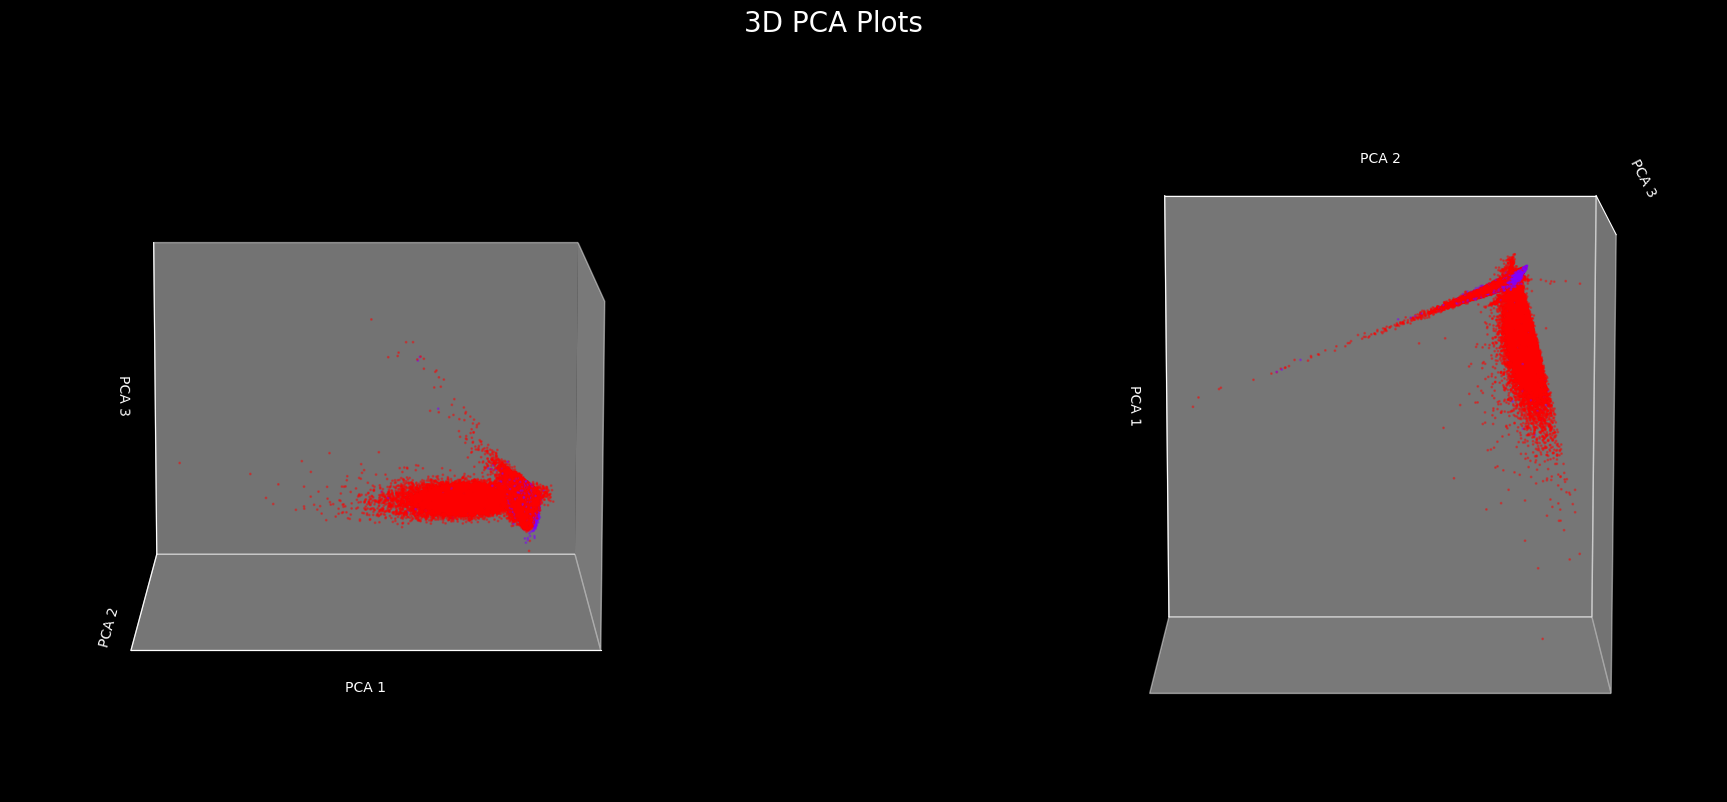

In [16]:
# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 3)
# fit the data
pca_vectors = pd.DataFrame(pca.fit_transform(no_cat), columns = ['1','2','3'])
# Combine the 2 components and the cluster that the label is a part of
pca_vectors = pd.concat([pca_vectors, y_binary], axis = 1)
# Create subplots so that multiple angles can be shown
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'), figsize = (24,9))
for i in range(2):
    ax[i].scatter(xs=pca_vectors['1'], ys=pca_vectors['2'], zs=pca_vectors['3'], 
                       c = pca_vectors.iloc[:,-1], s = 1, cmap='rainbow', alpha=.4) 
    # Label all the axes
    ax[i].set_xlabel('PCA 1', labelpad = .1)
    ax[i].set_ylabel('PCA 2', labelpad = .1)
    ax[i].set_zlabel('PCA 3', labelpad = .1)
    # Since values are meaningless in PCA, get rid of all the ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_zticks([])


ax[0].view_init(elev=10, azim=90)
ax[1].view_init(elev=1000, azim=180)

legend_labels = [i for i in range(1,9)]


plt.suptitle('3D PCA Plots', fontsize = 20)

plt.show()

In 3-D I get a very similar result where there isn't some amazing structure being obscured by only 2 dimensions. Whatever analysis can be done on this dataset won't include clustering.

Since the dataset has dates another thing to evaluate would be how the borrower's payments change over time. It could be that many of the borrowers have seasonal employment and so the payments will be cyclical or there may be other factors that impact the borrowers.

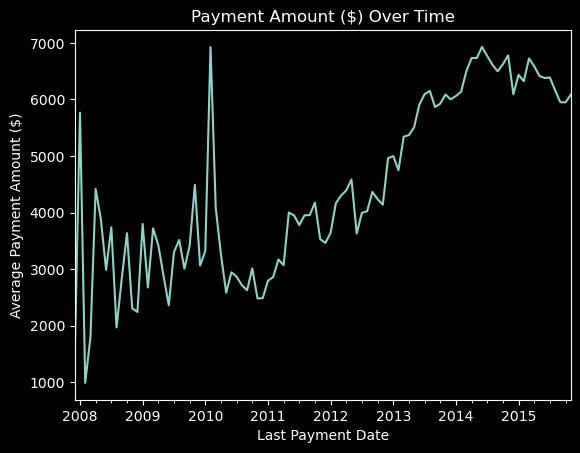

In [8]:
# Fill in every  missing value in last payment date with the issue date
loan['last_pymnt_d'].fillna(loan['issue_d'], inplace = True)
# convert to datetime so that I can graph it
loan['last_pymnt_d'] = pd.to_datetime(loan['last_pymnt_d'], format = r'%b-%Y')
# Create the data for the plot of the last payment amount by date to see macro trends effect the loans
loan_time = loan.groupby('last_pymnt_d').mean(numeric_only = True)['last_pymnt_amnt']
# Leave out the last two observations and plot the data
loan_time.iloc[:-2].plot();
# Label the x-axis as the dates
plt.xlabel("Last Payment Date");
# Label the y-axis as the payment
plt.ylabel("Average Payment Amount ($)");
# Label the graph as payment over time
plt.title("Payment Amount ($) Over Time");

In [13]:
loan.groupby('last_pymnt_d').agg({'last_pymnt_amnt':['mean','count']})

last_pymnt_amnt        
                        mean   count
last_pymnt_d                        
2007-12-01       1477.840000       2
2008-01-01       5767.189091      11
2008-02-01        986.263333       9
2008-03-01       1793.730526      19
2008-04-01       4416.551304      23
...                      ...     ...
2015-09-01       5951.271603   13865
2015-10-01       5947.040284   16038
2015-11-01       6083.851281   14048
2015-12-01        954.133144  167835
2016-01-01        514.195702  470150

[98 rows x 2 columns]

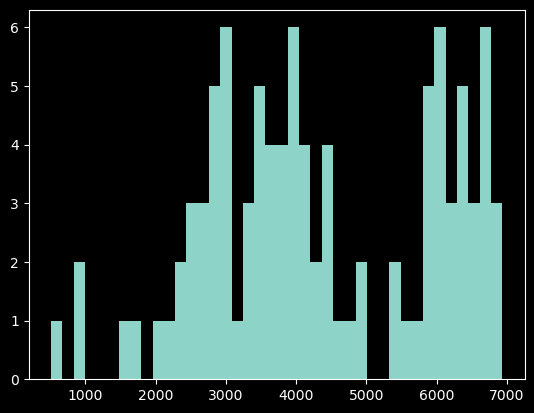

In [22]:
last_group = loan.groupby('last_pymnt_d').agg({'last_pymnt_amnt':['mean','count']})
plt.hist(last_group['last_pymnt_amnt']['mean'], bins = 40);

I do not have a reasonable explanation for the shape of this graph other than to assume that the economy has significantly changed from 2008 to 2016. In 2008 there was a tremendous financial crash that forced many Americans on hard times which is shown in the far left by the massive drop in loan payments. As the economy recovered the loan payments increased culminating in a spike in 2010. By using some webscraping I can find the percent change in the GDP and plot it against the loan payment date.

In [20]:
url = r"https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=US"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")
    exit()

In [59]:
response = requests.get(url)

# Create a BeautifulSoup object from the response text
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the anchor elements in the soup object
links = soup.find_all('a')

# Initialize an empty variable to store the CSV file URL
csv_url = None

# Loop through the links until you find the one that contains the CSV download link
for link in links:
    # Get the value of the href attribute from the link
    href = link.get('href')
    # Check if the href value ends with '.csv'
    if href != None:
        if href.endswith('csv'):
            # Assign the href value to the csv_url variable and break the loop
            csv_url = href
            break

# Check if the csv_url variable is not None
if csv_url is not None:
    # Send a GET request to the CSV file URL
    csv_response = requests.get(csv_url)
    # Store the response content in a variable
    csv_data = csv_response.content
    # Write the response content to a local file
    with open('./data/external/us_gdp.csv', 'wb') as f:
        f.write(csv_data)
        
else:
    # Print an error message if the csv_url variable is None
    print('Could not find the CSV download link')

In [60]:
# Open the zip file in read mode
with zipfile.ZipFile('./data/external/us_gdp.csv', 'r') as z:
    # Extract all the files in the zip file to the current working directory
    z.extractall('./data/external')

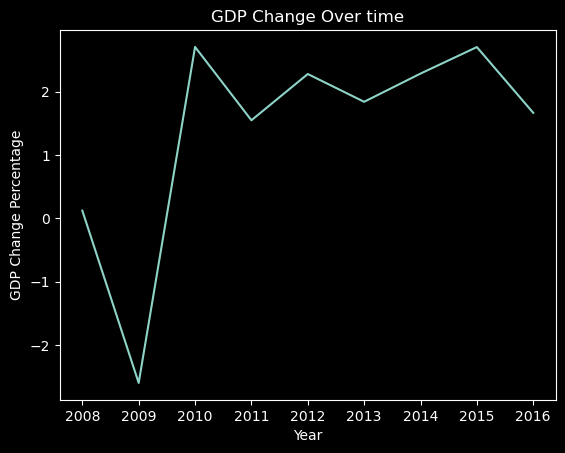

In [77]:
us_gdp = pd.read_csv(r'./data/external/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_5607116.csv', skiprows = 4)

us_gdp.T.iloc[-16:-7,251].plot();
plt.xlabel('Year');
plt.ylabel("GDP Change Percentage");
plt.title("GDP Change Over time");

The shape of this plot bears a large resemblance to the previous plot. This is concerning If I'm trying to do modelling because many of the variables that determine wether or not the borrower will be able to pay back the loan are outside the dataset. 